In [1]:
%load_ext autoreload
%autoreload 2

# Placeholder graphs
Graphs with dummy data

# Resources
- https://medium.com/@andykashyap/top-5-tricks-to-make-plots-look-better-9f6e687c1e08

In [2]:
import os
import pandas as pd
import numpy as np

from scipy import stats

import multiprocessing as mp
import itertools
import tqdm

import matplotlib.pyplot as plt
import matplotlib.style as style
import matplotlib.cm as cm
import matplotlib.colors as mcolors

from libphase.scripts.simpoint import simpoint

import seaborn as sns

style.use('seaborn-poster') #sets the size of the charts
style.use('ggplot')
sns.set(context="talk", style="ticks", font_scale=1.5)

pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

# Chapter 2: Challenges and opportunities

## 1. Use fixed, non-overlapping windows

### Simple example

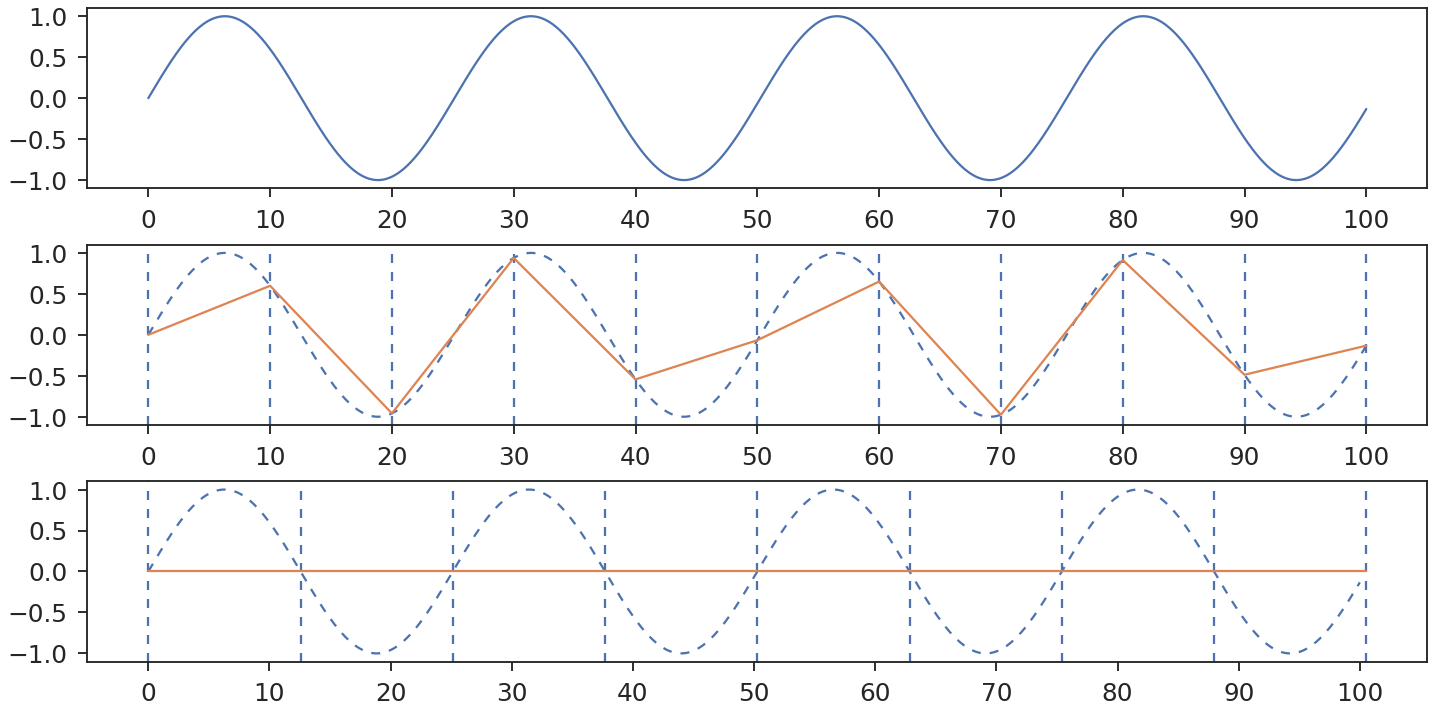

In [3]:
xs = np.linspace(0, 100, 1001)
sin = np.sin((xs + 10) * (np.pi) / 10)
sin = np.sin(xs / 4)

dashes = (4, 4, 4, 4)

fig, ax = plt.subplots()
fig.set_size_inches(20, 10)

plt.subplot(3, 1, 1)
plt.plot(xs, sin)
plt.xticks(np.linspace(0, 100, 11))
plt.yticks(np.linspace(-1, 1, 5))

plt.subplot(3, 1, 2)
plt.plot(xs, sin, dashes=dashes)
plt.xticks(np.linspace(0, 100, 11))
plt.yticks(np.linspace(-1, 1, 5))

for i in np.linspace(0, 100, 11):
    plt.axvline(x=i, ymin=0, ymax=1, dashes=dashes)

plt.plot(np.linspace(0, 100, 11), np.sin(np.linspace(0, 100, 11) / 4))

plt.subplot(3, 1, 3)
plt.plot(xs, sin, dashes=dashes)
plt.xticks(np.linspace(0, 100, 11))
plt.yticks(np.linspace(-1, 1, 5))
for i in np.arange(0, 101, 4 * np.pi):
    plt.axvline(x=i, ymin=0, ymax=1, dashes=dashes)
    
plt.plot(np.arange(0, 101, 4 * np.pi), np.sin(np.arange(0, 101, 4 * np.pi)))

fig.tight_layout(pad=1.0)

### Shifting / scaling

In [4]:
# Units of millions
path = "../tmp/spec_1m/500.perlbench_r.1.bbv"

In [5]:
def shiftscale(path, shift = 0, scale = 1):
    print("{}: {} {}".format(path, shift, scale))
    mpath = path.replace("bbv", "{}.{}.bbv".format(shift, scale))
    out = open(mpath, "w")
    with open(path, "r") as f:
        nline = 0
        interval = {}

        for line in f:

            # Skip all lines that don't begin with T
            if line[0] != "T":
                continue

            nline += 1

            # Shift by certain number of intervals
            if nline <= shift:
                continue

            # Start new window
            if (nline - shift - 1) % scale == 0:
                if len(interval.keys()) > 0:
                    # write
                    to_write = "T" + " ".join([":{}:{}".format(key, interval[key]) for key in interval])
                    out.write(to_write)
                    out.write("\n")

                # Create a new interval
                interval = {}

            bbv = line[1:].split()
            for bb in bbv:
                key, val = bb.split(":")[1:]
                if key in interval:
                    interval[key] += int(val)
                else:
                    interval[key] = int(val)

In [6]:
shifts = np.arange(100, 1000, 100)

In [7]:
shifts

array([100, 200, 300, 400, 500, 600, 700, 800, 900])

In [8]:
scales = [1000]

In [9]:
args = itertools.product([path], shifts, scales)

In [10]:
args, num_jobs = itertools.tee(args)
num_jobs = len(list(num_jobs))

In [11]:
num_jobs

9

In [12]:
def runner(args):
    return shiftscale(*args)

In [13]:
# with mp.Pool(processes=mp.cpu_count()) as pool:
#     result = list(tqdm.tqdm(pool.imap(runner, args), total=num_jobs))

In [14]:
bbv_paths = !find "../tmp/bbv" | grep "500.perlbench_r.1" | grep "bbv"

In [ ]:
for bbv_path in bbv_paths:
    shift, scale = bbv_path.split("/")[-1].split(".")[3:5]
    simpoint(bbv_path, None, 30, False, "{}.{}".format(shift, scale), True, True, None)

{'bbv_file': '../tmp/bbv/500.perlbench_r.1.8000.10000.bbv', 'k': None, 'max_k': 30, 'variable_length': False, 'output_dir': '8000.10000', 'verbose': True, 'args': None}
/home/dsuo/libphase/tmp/bbv/8000.10000
Command:  /home/dsuo/libphase/build/deps/simpoint/simpoint-git-prefix/src/simpoint-git/bin/simpoint -loadFVFile ../tmp/bbv/500.perlbench_r.1.8000.10000.bbv -saveSimpoints /home/dsuo/libphase/tmp/bbv/8000.10000/out.simpoints -saveSimpointWeights /home/dsuo/libphase/tmp/bbv/8000.10000/out.weights -saveFinalCtrs /home/dsuo/libphase/tmp/bbv/8000.10000/out.centres -saveLabels /home/dsuo/libphase/tmp/bbv/8000.10000/out.labels -maxK 30
Command-line: "/home/dsuo/libphase/build/deps/simpoint/simpoint-git-prefix/src/simpoint-git/bin/simpoint -loadFVFile ../tmp/bbv/500.perlbench_r.1.8000.10000.bbv -saveSimpoints /home/dsuo/libphase/tmp/bbv/8000.10000/out.simpoints -saveSimpointWeights /home/dsuo/libphase/tmp/bbv/8000.10000/out.weights -saveFinalCtrs /home/dsuo/libphase/tmp/bbv/8000.10000/out.

Command-line: "/home/dsuo/libphase/build/deps/simpoint/simpoint-git-prefix/src/simpoint-git/bin/simpoint -loadFVFile ../tmp/bbv/500.perlbench_r.1.600.1000.bbv -saveSimpoints /home/dsuo/libphase/tmp/bbv/600.1000/out.simpoints -saveSimpointWeights /home/dsuo/libphase/tmp/bbv/600.1000/out.weights -saveFinalCtrs /home/dsuo/libphase/tmp/bbv/600.1000/out.centres -saveLabels /home/dsuo/libphase/tmp/bbv/600.1000/out.labels -maxK 30"
Using these options (*** indicates user-specified option):
*** -loadFVFile : ../tmp/bbv/500.perlbench_r.1.600.1000.bbv
    -k : search
    -iters : 100
    -dim : 15
*** -maxK : 30
    -numInitSeeds : 5
    -coveragePct : 1
    -bicThreshold : 0.9
    -saveAll : false
    -initkm : samp
*** -saveLabels : /home/dsuo/libphase/tmp/bbv/600.1000/out.labels
*** -saveSimpoints : /home/dsuo/libphase/tmp/bbv/600.1000/out.simpoints
*** -saveSimpointWeights : /home/dsuo/libphase/tmp/bbv/600.1000/out.weights
    -saveVectorWeights : 
    -saveInitCtrs : 
*** -saveFinalCtrs : /

Command-line: "/home/dsuo/libphase/build/deps/simpoint/simpoint-git-prefix/src/simpoint-git/bin/simpoint -loadFVFile ../tmp/bbv/500.perlbench_r.1.1000.10000.bbv -saveSimpoints /home/dsuo/libphase/tmp/bbv/1000.10000/out.simpoints -saveSimpointWeights /home/dsuo/libphase/tmp/bbv/1000.10000/out.weights -saveFinalCtrs /home/dsuo/libphase/tmp/bbv/1000.10000/out.centres -saveLabels /home/dsuo/libphase/tmp/bbv/1000.10000/out.labels -maxK 30"
Using these options (*** indicates user-specified option):
*** -loadFVFile : ../tmp/bbv/500.perlbench_r.1.1000.10000.bbv
    -k : search
    -iters : 100
    -dim : 15
*** -maxK : 30
    -numInitSeeds : 5
    -coveragePct : 1
    -bicThreshold : 0.9
    -saveAll : false
    -initkm : samp
*** -saveLabels : /home/dsuo/libphase/tmp/bbv/1000.10000/out.labels
*** -saveSimpoints : /home/dsuo/libphase/tmp/bbv/1000.10000/out.simpoints
*** -saveSimpointWeights : /home/dsuo/libphase/tmp/bbv/1000.10000/out.weights
    -saveVectorWeights : 
    -saveInitCtrs : 
*** 

Command-line: "/home/dsuo/libphase/build/deps/simpoint/simpoint-git-prefix/src/simpoint-git/bin/simpoint -loadFVFile ../tmp/bbv/500.perlbench_r.1.400.1000.bbv -saveSimpoints /home/dsuo/libphase/tmp/bbv/400.1000/out.simpoints -saveSimpointWeights /home/dsuo/libphase/tmp/bbv/400.1000/out.weights -saveFinalCtrs /home/dsuo/libphase/tmp/bbv/400.1000/out.centres -saveLabels /home/dsuo/libphase/tmp/bbv/400.1000/out.labels -maxK 30"
Using these options (*** indicates user-specified option):
*** -loadFVFile : ../tmp/bbv/500.perlbench_r.1.400.1000.bbv
    -k : search
    -iters : 100
    -dim : 15
*** -maxK : 30
    -numInitSeeds : 5
    -coveragePct : 1
    -bicThreshold : 0.9
    -saveAll : false
    -initkm : samp
*** -saveLabels : /home/dsuo/libphase/tmp/bbv/400.1000/out.labels
*** -saveSimpoints : /home/dsuo/libphase/tmp/bbv/400.1000/out.simpoints
*** -saveSimpointWeights : /home/dsuo/libphase/tmp/bbv/400.1000/out.weights
    -saveVectorWeights : 
    -saveInitCtrs : 
*** -saveFinalCtrs : /

Command-line: "/home/dsuo/libphase/build/deps/simpoint/simpoint-git-prefix/src/simpoint-git/bin/simpoint -loadFVFile ../tmp/bbv/500.perlbench_r.1.200.1000.bbv -saveSimpoints /home/dsuo/libphase/tmp/bbv/200.1000/out.simpoints -saveSimpointWeights /home/dsuo/libphase/tmp/bbv/200.1000/out.weights -saveFinalCtrs /home/dsuo/libphase/tmp/bbv/200.1000/out.centres -saveLabels /home/dsuo/libphase/tmp/bbv/200.1000/out.labels -maxK 30"
Using these options (*** indicates user-specified option):
*** -loadFVFile : ../tmp/bbv/500.perlbench_r.1.200.1000.bbv
    -k : search
    -iters : 100
    -dim : 15
*** -maxK : 30
    -numInitSeeds : 5
    -coveragePct : 1
    -bicThreshold : 0.9
    -saveAll : false
    -initkm : samp
*** -saveLabels : /home/dsuo/libphase/tmp/bbv/200.1000/out.labels
*** -saveSimpoints : /home/dsuo/libphase/tmp/bbv/200.1000/out.simpoints
*** -saveSimpointWeights : /home/dsuo/libphase/tmp/bbv/200.1000/out.weights
    -saveVectorWeights : 
    -saveInitCtrs : 
*** -saveFinalCtrs : /

Command-line: "/home/dsuo/libphase/build/deps/simpoint/simpoint-git-prefix/src/simpoint-git/bin/simpoint -loadFVFile ../tmp/bbv/500.perlbench_r.1.3000.10000.bbv -saveSimpoints /home/dsuo/libphase/tmp/bbv/3000.10000/out.simpoints -saveSimpointWeights /home/dsuo/libphase/tmp/bbv/3000.10000/out.weights -saveFinalCtrs /home/dsuo/libphase/tmp/bbv/3000.10000/out.centres -saveLabels /home/dsuo/libphase/tmp/bbv/3000.10000/out.labels -maxK 30"
Using these options (*** indicates user-specified option):
*** -loadFVFile : ../tmp/bbv/500.perlbench_r.1.3000.10000.bbv
    -k : search
    -iters : 100
    -dim : 15
*** -maxK : 30
    -numInitSeeds : 5
    -coveragePct : 1
    -bicThreshold : 0.9
    -saveAll : false
    -initkm : samp
*** -saveLabels : /home/dsuo/libphase/tmp/bbv/3000.10000/out.labels
*** -saveSimpoints : /home/dsuo/libphase/tmp/bbv/3000.10000/out.simpoints
*** -saveSimpointWeights : /home/dsuo/libphase/tmp/bbv/3000.10000/out.weights
    -saveVectorWeights : 
    -saveInitCtrs : 
*** 

Command-line: "/home/dsuo/libphase/build/deps/simpoint/simpoint-git-prefix/src/simpoint-git/bin/simpoint -loadFVFile ../tmp/bbv/500.perlbench_r.1.5000.10000.bbv -saveSimpoints /home/dsuo/libphase/tmp/bbv/5000.10000/out.simpoints -saveSimpointWeights /home/dsuo/libphase/tmp/bbv/5000.10000/out.weights -saveFinalCtrs /home/dsuo/libphase/tmp/bbv/5000.10000/out.centres -saveLabels /home/dsuo/libphase/tmp/bbv/5000.10000/out.labels -maxK 30"
Using these options (*** indicates user-specified option):
*** -loadFVFile : ../tmp/bbv/500.perlbench_r.1.5000.10000.bbv
    -k : search
    -iters : 100
    -dim : 15
*** -maxK : 30
    -numInitSeeds : 5
    -coveragePct : 1
    -bicThreshold : 0.9
    -saveAll : false
    -initkm : samp
*** -saveLabels : /home/dsuo/libphase/tmp/bbv/5000.10000/out.labels
*** -saveSimpoints : /home/dsuo/libphase/tmp/bbv/5000.10000/out.simpoints
*** -saveSimpointWeights : /home/dsuo/libphase/tmp/bbv/5000.10000/out.weights
    -saveVectorWeights : 
    -saveInitCtrs : 
*** 

Command-line: "/home/dsuo/libphase/build/deps/simpoint/simpoint-git-prefix/src/simpoint-git/bin/simpoint -loadFVFile ../tmp/bbv/500.perlbench_r.1.0.1.bbv -saveSimpoints /home/dsuo/libphase/tmp/bbv/0.1/out.simpoints -saveSimpointWeights /home/dsuo/libphase/tmp/bbv/0.1/out.weights -saveFinalCtrs /home/dsuo/libphase/tmp/bbv/0.1/out.centres -saveLabels /home/dsuo/libphase/tmp/bbv/0.1/out.labels -maxK 30"
Using these options (*** indicates user-specified option):
*** -loadFVFile : ../tmp/bbv/500.perlbench_r.1.0.1.bbv
    -k : search
    -iters : 100
    -dim : 15
*** -maxK : 30
    -numInitSeeds : 5
    -coveragePct : 1
    -bicThreshold : 0.9
    -saveAll : false
    -initkm : samp
*** -saveLabels : /home/dsuo/libphase/tmp/bbv/0.1/out.labels
*** -saveSimpoints : /home/dsuo/libphase/tmp/bbv/0.1/out.simpoints
*** -saveSimpointWeights : /home/dsuo/libphase/tmp/bbv/0.1/out.weights
    -saveVectorWeights : 
    -saveInitCtrs : 
*** -saveFinalCtrs : /home/dsuo/libphase/tmp/bbv/0.1/out.centres
  

Command-line: "/home/dsuo/libphase/build/deps/simpoint/simpoint-git-prefix/src/simpoint-git/bin/simpoint -loadFVFile ../tmp/bbv/500.perlbench_r.1.300.1000.bbv -saveSimpoints /home/dsuo/libphase/tmp/bbv/300.1000/out.simpoints -saveSimpointWeights /home/dsuo/libphase/tmp/bbv/300.1000/out.weights -saveFinalCtrs /home/dsuo/libphase/tmp/bbv/300.1000/out.centres -saveLabels /home/dsuo/libphase/tmp/bbv/300.1000/out.labels -maxK 30"
Using these options (*** indicates user-specified option):
*** -loadFVFile : ../tmp/bbv/500.perlbench_r.1.300.1000.bbv
    -k : search
    -iters : 100
    -dim : 15
*** -maxK : 30
    -numInitSeeds : 5
    -coveragePct : 1
    -bicThreshold : 0.9
    -saveAll : false
    -initkm : samp
*** -saveLabels : /home/dsuo/libphase/tmp/bbv/300.1000/out.labels
*** -saveSimpoints : /home/dsuo/libphase/tmp/bbv/300.1000/out.simpoints
*** -saveSimpointWeights : /home/dsuo/libphase/tmp/bbv/300.1000/out.weights
    -saveVectorWeights : 
    -saveInitCtrs : 
*** -saveFinalCtrs : /

Command-line: "/home/dsuo/libphase/build/deps/simpoint/simpoint-git-prefix/src/simpoint-git/bin/simpoint -loadFVFile ../tmp/bbv/500.perlbench_r.1.7000.10000.bbv -saveSimpoints /home/dsuo/libphase/tmp/bbv/7000.10000/out.simpoints -saveSimpointWeights /home/dsuo/libphase/tmp/bbv/7000.10000/out.weights -saveFinalCtrs /home/dsuo/libphase/tmp/bbv/7000.10000/out.centres -saveLabels /home/dsuo/libphase/tmp/bbv/7000.10000/out.labels -maxK 30"
Using these options (*** indicates user-specified option):
*** -loadFVFile : ../tmp/bbv/500.perlbench_r.1.7000.10000.bbv
    -k : search
    -iters : 100
    -dim : 15
*** -maxK : 30
    -numInitSeeds : 5
    -coveragePct : 1
    -bicThreshold : 0.9
    -saveAll : false
    -initkm : samp
*** -saveLabels : /home/dsuo/libphase/tmp/bbv/7000.10000/out.labels
*** -saveSimpoints : /home/dsuo/libphase/tmp/bbv/7000.10000/out.simpoints
*** -saveSimpointWeights : /home/dsuo/libphase/tmp/bbv/7000.10000/out.weights
    -saveVectorWeights : 
    -saveInitCtrs : 
*** 

Command-line: "/home/dsuo/libphase/build/deps/simpoint/simpoint-git-prefix/src/simpoint-git/bin/simpoint -loadFVFile ../tmp/bbv/500.perlbench_r.1.10.50.bbv -saveSimpoints /home/dsuo/libphase/tmp/bbv/10.50/out.simpoints -saveSimpointWeights /home/dsuo/libphase/tmp/bbv/10.50/out.weights -saveFinalCtrs /home/dsuo/libphase/tmp/bbv/10.50/out.centres -saveLabels /home/dsuo/libphase/tmp/bbv/10.50/out.labels -maxK 30"
Using these options (*** indicates user-specified option):
*** -loadFVFile : ../tmp/bbv/500.perlbench_r.1.10.50.bbv
    -k : search
    -iters : 100
    -dim : 15
*** -maxK : 30
    -numInitSeeds : 5
    -coveragePct : 1
    -bicThreshold : 0.9
    -saveAll : false
    -initkm : samp
*** -saveLabels : /home/dsuo/libphase/tmp/bbv/10.50/out.labels
*** -saveSimpoints : /home/dsuo/libphase/tmp/bbv/10.50/out.simpoints
*** -saveSimpointWeights : /home/dsuo/libphase/tmp/bbv/10.50/out.weights
    -saveVectorWeights : 
    -saveInitCtrs : 
*** -saveFinalCtrs : /home/dsuo/libphase/tmp/bbv/

Command-line: "/home/dsuo/libphase/build/deps/simpoint/simpoint-git-prefix/src/simpoint-git/bin/simpoint -loadFVFile ../tmp/bbv/500.perlbench_r.1.100.1000.bbv -saveSimpoints /home/dsuo/libphase/tmp/bbv/100.1000/out.simpoints -saveSimpointWeights /home/dsuo/libphase/tmp/bbv/100.1000/out.weights -saveFinalCtrs /home/dsuo/libphase/tmp/bbv/100.1000/out.centres -saveLabels /home/dsuo/libphase/tmp/bbv/100.1000/out.labels -maxK 30"
Using these options (*** indicates user-specified option):
*** -loadFVFile : ../tmp/bbv/500.perlbench_r.1.100.1000.bbv
    -k : search
    -iters : 100
    -dim : 15
*** -maxK : 30
    -numInitSeeds : 5
    -coveragePct : 1
    -bicThreshold : 0.9
    -saveAll : false
    -initkm : samp
*** -saveLabels : /home/dsuo/libphase/tmp/bbv/100.1000/out.labels
*** -saveSimpoints : /home/dsuo/libphase/tmp/bbv/100.1000/out.simpoints
*** -saveSimpointWeights : /home/dsuo/libphase/tmp/bbv/100.1000/out.weights
    -saveVectorWeights : 
    -saveInitCtrs : 
*** -saveFinalCtrs : /

Command-line: "/home/dsuo/libphase/build/deps/simpoint/simpoint-git-prefix/src/simpoint-git/bin/simpoint -loadFVFile ../tmp/bbv/500.perlbench_r.1.900.1000.bbv -saveSimpoints /home/dsuo/libphase/tmp/bbv/900.1000/out.simpoints -saveSimpointWeights /home/dsuo/libphase/tmp/bbv/900.1000/out.weights -saveFinalCtrs /home/dsuo/libphase/tmp/bbv/900.1000/out.centres -saveLabels /home/dsuo/libphase/tmp/bbv/900.1000/out.labels -maxK 30"
Using these options (*** indicates user-specified option):
*** -loadFVFile : ../tmp/bbv/500.perlbench_r.1.900.1000.bbv
    -k : search
    -iters : 100
    -dim : 15
*** -maxK : 30
    -numInitSeeds : 5
    -coveragePct : 1
    -bicThreshold : 0.9
    -saveAll : false
    -initkm : samp
*** -saveLabels : /home/dsuo/libphase/tmp/bbv/900.1000/out.labels
*** -saveSimpoints : /home/dsuo/libphase/tmp/bbv/900.1000/out.simpoints
*** -saveSimpointWeights : /home/dsuo/libphase/tmp/bbv/900.1000/out.weights
    -saveVectorWeights : 
    -saveInitCtrs : 
*** -saveFinalCtrs : /

Command-line: "/home/dsuo/libphase/build/deps/simpoint/simpoint-git-prefix/src/simpoint-git/bin/simpoint -loadFVFile ../tmp/bbv/500.perlbench_r.1.6000.10000.bbv -saveSimpoints /home/dsuo/libphase/tmp/bbv/6000.10000/out.simpoints -saveSimpointWeights /home/dsuo/libphase/tmp/bbv/6000.10000/out.weights -saveFinalCtrs /home/dsuo/libphase/tmp/bbv/6000.10000/out.centres -saveLabels /home/dsuo/libphase/tmp/bbv/6000.10000/out.labels -maxK 30"
Using these options (*** indicates user-specified option):
*** -loadFVFile : ../tmp/bbv/500.perlbench_r.1.6000.10000.bbv
    -k : search
    -iters : 100
    -dim : 15
*** -maxK : 30
    -numInitSeeds : 5
    -coveragePct : 1
    -bicThreshold : 0.9
    -saveAll : false
    -initkm : samp
*** -saveLabels : /home/dsuo/libphase/tmp/bbv/6000.10000/out.labels
*** -saveSimpoints : /home/dsuo/libphase/tmp/bbv/6000.10000/out.simpoints
*** -saveSimpointWeights : /home/dsuo/libphase/tmp/bbv/6000.10000/out.weights
    -saveVectorWeights : 
    -saveInitCtrs : 
*** 